In [ ]:
import os
# Набор утилит для работы с файловой системой
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Импортируем генератор изображений
from keras import models, layers, optimizers, applications
from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Построение графиков
import numpy as np                        # Работа с матрицами


%matplotlib inline


IMG_WIDTH = 150
IMG_HEIGHT = 150

# Получение и обзор данных

## Скачка

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip

--2025-07-04 12:04:37--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip’

cat-and-dog.zip     100%[===================>] 217.52M  16.0MB/s    in 13s     

2025-07-04 12:04:51 (16.3 MB/s) - ‘cat-and-dog.zip’ saved [228082266/228082266]



In [ ]:
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "cat-and-dog" -d ./temp

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './temp/training_set/training_set/'

# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

In [ ]:
#Посмотрим что скачали
os.listdir(IMAGE_PATH)

['cats', 'dogs']

In [ ]:
# Разберемся с классами
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['cats', 'dogs']


In [ ]:
# Создадим соответствие путь к файлу - класс
data_files = []  # Cписок путей к файлам изображений
data_labels = [] # Список меток классов

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Полный путь к папке с изображениями класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(class_path)

    # Вывод информации о численности класса
    print(f'Размер класса {class_name} составляет {len(class_files)} животных')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса cats составляет 4000 животных
Размер класса dogs составляет 4005 животных
Общий размер базы для обучения: 8005



## Разделение на тест-трейн-вал

In [ ]:
# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

In [ ]:
# Функция создания подвыборок (папок с файлами)
def create_dataset(
    img_path: str,         # Путь к файлам с изображениями классов
    new_path: str,         # Путь к папке с выборками
    class_name: str,       # Имя класса (оно же и имя папки)
    start_index: int,      # Стартовый индекс изображения, с которого начинаем подвыборку
    end_index: int         # Конечный индекс изображения, до которого создаем подвыборку

):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    # Перебираем элементы, отобранного списка с начального по конечный индекс
    for fname in class_files[start_index : end_index]:
        # Путь к файлу (источник)
        src = os.path.join(src_path, fname)
        # Новый путь расположения файла (назначение)
        dst = os.path.join(dst_path, fname)
        # Копируем файл из источника в новое место (назначение)
        shutil.copyfile(src, dst)

In [ ]:
# Создадим наборы для каждого класса
for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 2000)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 2000, 3000)
    create_dataset(IMAGE_PATH, test_dir, class_name, 3000, 4001)


In [ ]:
print('Число кошек %s, число собак %s в обучающей выборке' \
      % (
          len(os.listdir(os.path.join(train_dir, 'cats'))),
          len(os.listdir(os.path.join(train_dir, 'dogs')))
         )
      )

print('Число кошек %s, число собак %s в проверочной выборке' \
      % (
          len(os.listdir(os.path.join(validation_dir, 'cats'))),
          len(os.listdir(os.path.join(validation_dir, 'dogs')))
         )
      )

print('Число кошек %s, число собак %s в контрольной выборке' \
      % (
          len(os.listdir(os.path.join(test_dir, 'cats'))),
          len(os.listdir(os.path.join(test_dir, 'dogs')))
         )
      )

Число кошек 2000, число собак 2000 в обучающей выборке
Число кошек 1000, число собак 1000 в проверочной выборке
Число кошек 1000, число собак 1001 в контрольной выборке


## Батч-генераторы (вместе с предобработкой и агументацией)


In [ ]:
BATCH_SIZE = 20

# Создаем генераторы для выборок
def gen_create(dir):
    # Предварительно нормализуем данные делением на 255, приводим интесивность пикселей картинки к диапазону от 0 до 1
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # Генерируем мини-батчи для обучения из заданной директории
    generator = datagen.flow_from_directory(
        dir, # Целевой каталог
        target_size=(IMG_WIDTH, IMG_HEIGHT), # Привести все изображения к размеру 150 × 150
        batch_size=BATCH_SIZE, # Размер батча
        class_mode='categorical',  #
    )
    return generator


train_generator, validation_generator, test_generator = [
    gen_create(dir) for dir in [
        train_dir
        ,validation_dir
        ,test_dir
    ]
]

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('Форма пакета с изображениями:', data_batch.shape)
    print('Форма пакета с метками:', labels_batch.shape)
    break

Форма пакета с изображениями: (20, 150, 150, 3)
Форма пакета с метками: (20, 2)


In [ ]:
# Функция рисования образцов изображений из заданного батча генератора
def show_batch(batch,                # батч с примерами
               img_range=range(BATCH_SIZE),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range: # Перебираем диапазон номеров картинок
        ix = i % columns # Отображаем по 5 (или другое число, заданное columns) в строку
        # Остаток от деления на 5 равный нулю говорит, что пора перейти на следующую строку (новый график)
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize) # Область построения графика: одна строка в 5 колонок
        class_label = int(np.argmax(batch[1][i])) # Извлекаем номер класса
        ax[ix].set_title(CLASS_LIST[class_label]) # Отображаем заголовок конкретного рисунка
        ax[ix].imshow(batch[0][i]) # Отображаем изображение животного на графике
        ax[ix].axis('off') # Отключаем отображение осей на графике
        plt.tight_layout() # Автоматически настраивает параметры подзаголовка так, чтобы подзаголовок вписывался в область рисунка

    plt.show() # Отображаем все графики со всеми рисунками

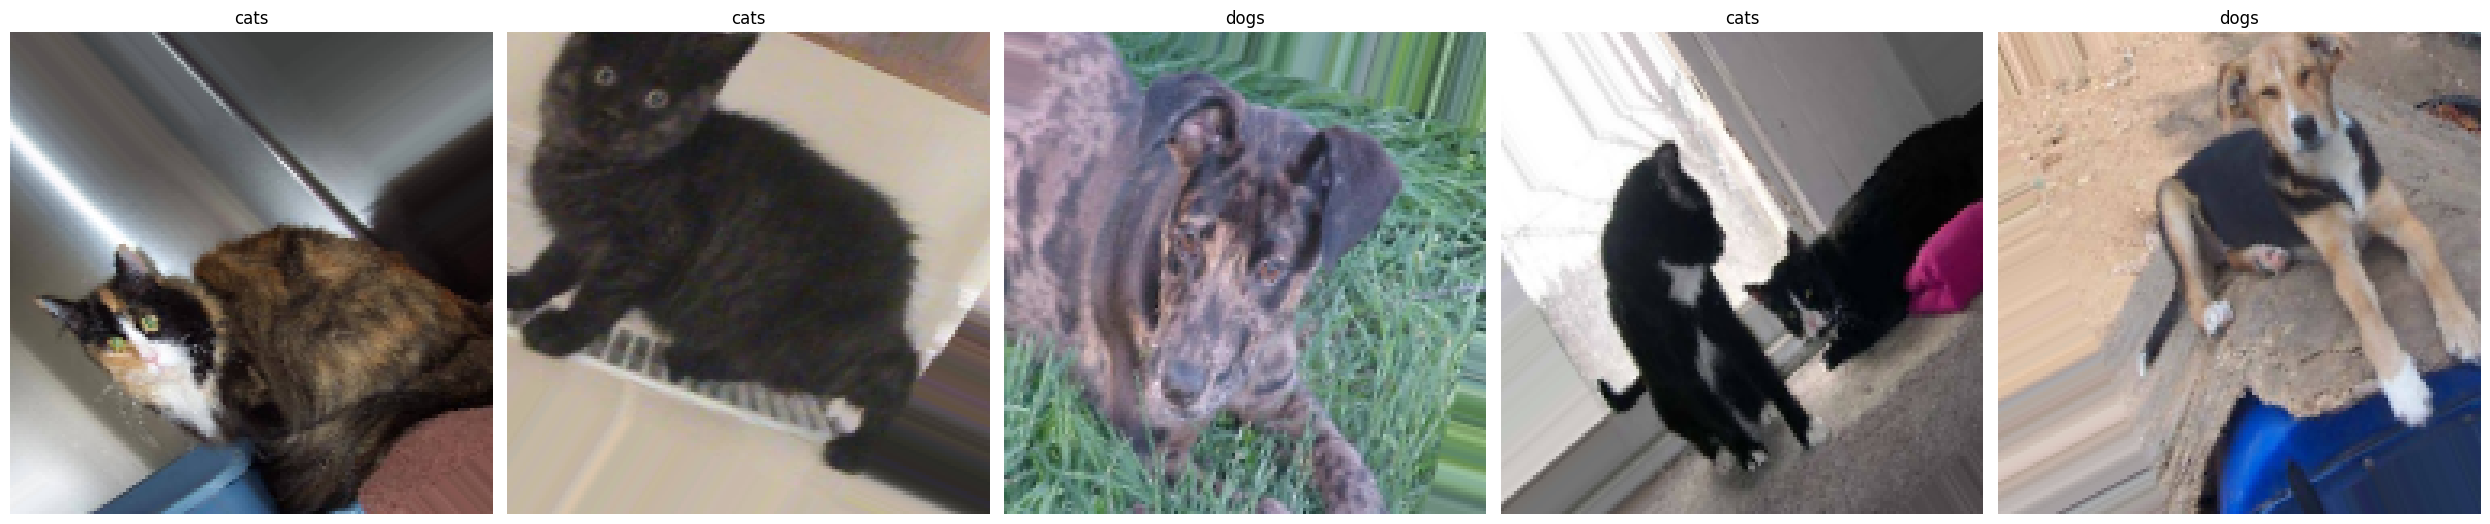

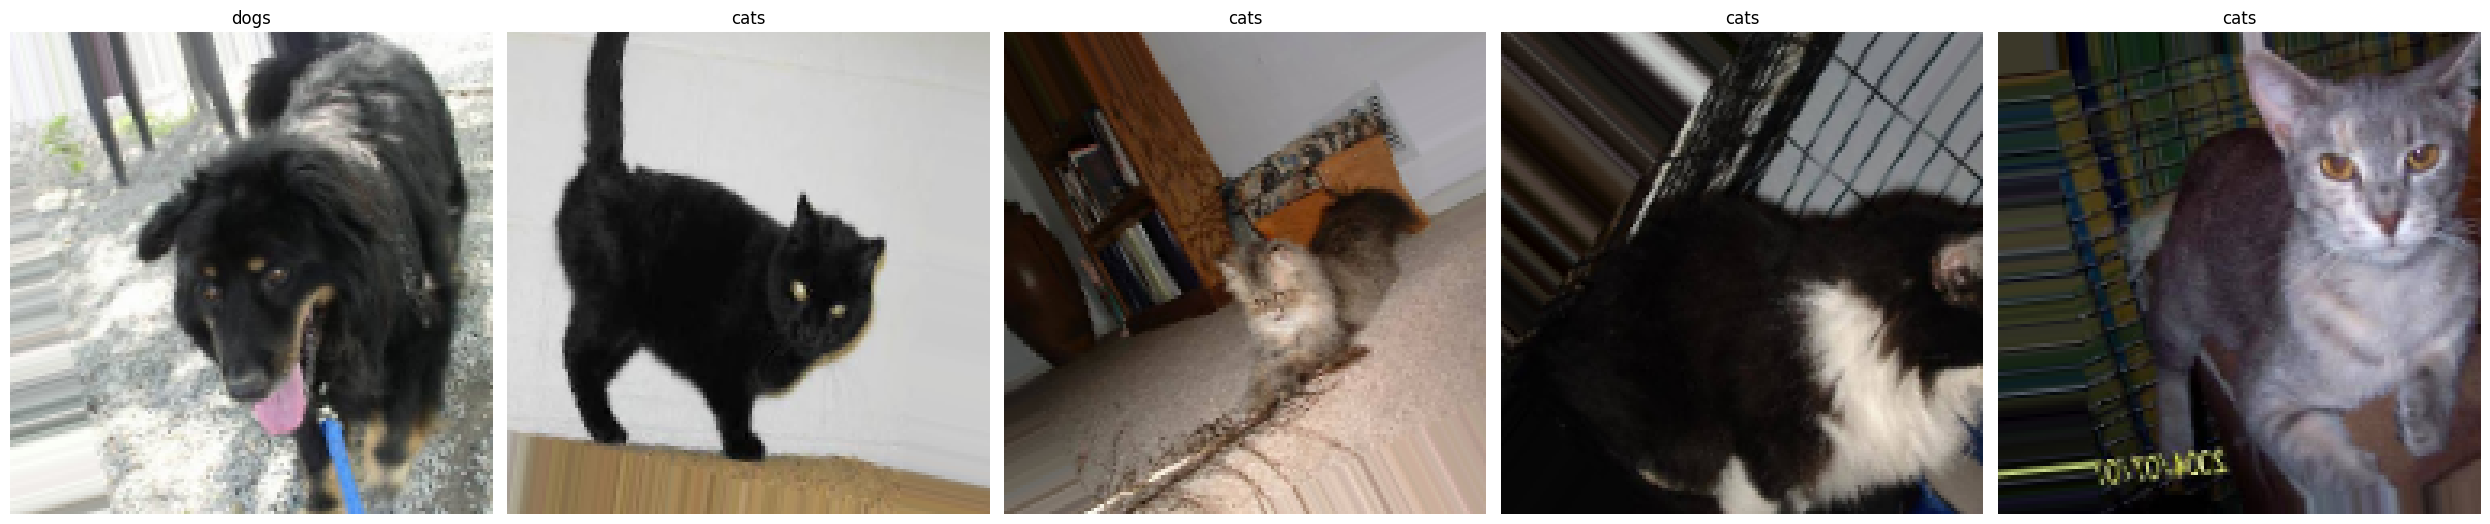

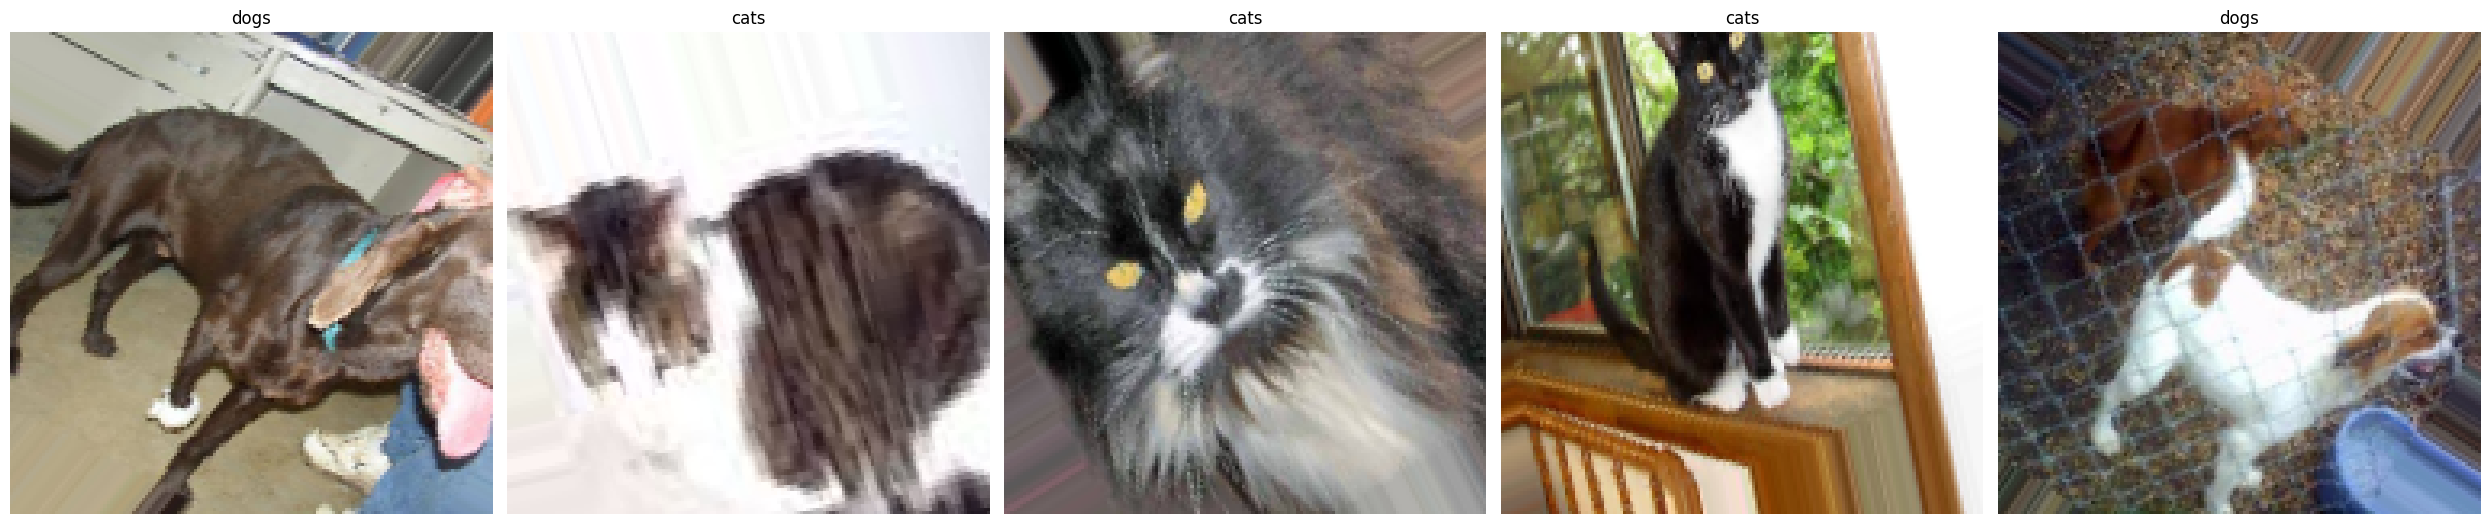

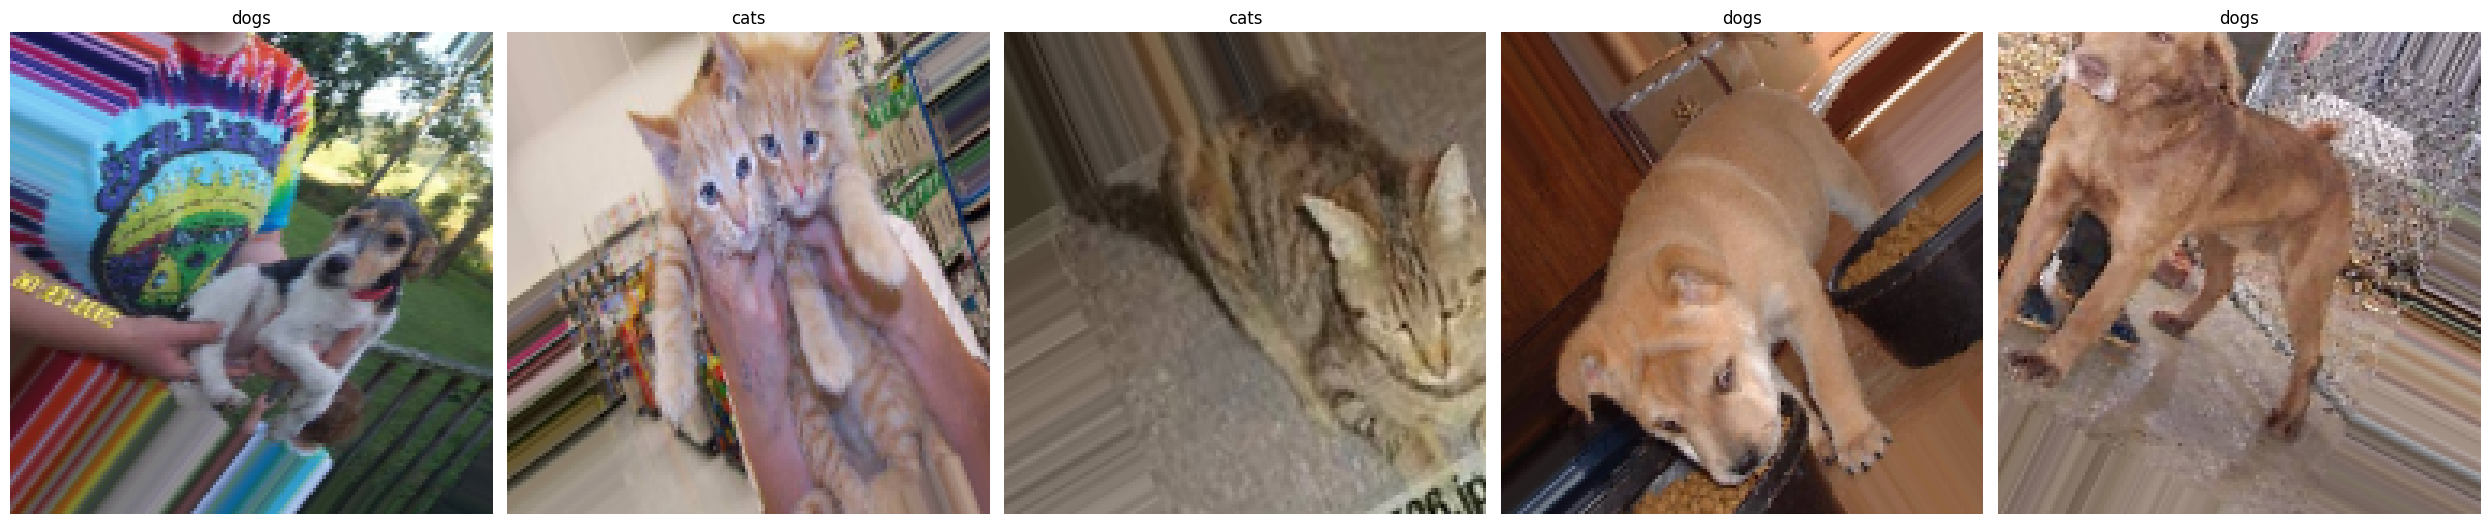

In [ ]:
show_batch(validation_generator[0]) # рисуем батч

# Обучение

## Создание модели

In [ ]:
def model_maker():
    base_model = applications.MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:-2]:
        layer.trainable = False

    input = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = layers.GlobalAveragePooling2D()(custom_model)
    custom_model = layers.Dense(64, activation='relu')(custom_model)
    custom_model = layers.Dropout(0.5)(custom_model)
    predictions = layers.Dense(CLASS_COUNT, activation='softmax')(custom_model)

    model = models.Model(inputs=input, outputs=predictions)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=['acc']
    )

    return model

model_maker().summary()

/tmp/ipython-input-21-1519421847.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,594 (12.57 MB)

 Trainable params: 67,778 (264.76 KB)

 Non-trainable params: 3,226,816 (12.31 MB)

In [ ]:
model = model_maker()
# цикл обучения
history = model.fit(
    train_generator,                        # генератор для обучения
    epochs=30,                              # число эпох обучения
    validation_data=validation_generator,   # генератор проверочной выборки
)
model.save('cats_and_dogs_small_model.h5') # сохраняем модель

/tmp/ipython-input-21-1519421847.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - acc: 0.6136 - loss: 0.7777 - val_acc: 0.9000 - val_loss: 0.2765
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - acc: 0.8698 - loss: 0.3445 - val_acc: 0.9220 - val_loss: 0.2108
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - acc: 0.8850 - loss: 0.2884 - val_acc: 0.9305 - val_loss: 0.1807
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - acc: 0.9030 - loss: 0.2565 - val_acc: 0.9330 - val_loss: 0.1755
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - acc: 0.8952 - loss: 0.2417 - val_acc: 0.9340 - val_loss: 0.1643
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - acc: 0.8977 - loss: 0.2379 - val_acc: 0.9385 - val_loss: 0.1507
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - acc: 0.9123 - loss: 0.2285 - val_acc: 0.9400 - val_loss: 0.1442
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - acc: 0.9189 - loss: 0.2080 - val_acc: 0.9515 - val_loss: 0.1382
Epoch 9/30
200/200 ━━━━━━━━━━━━━

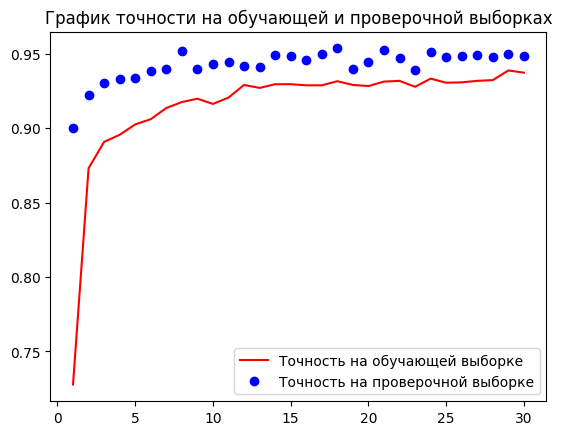

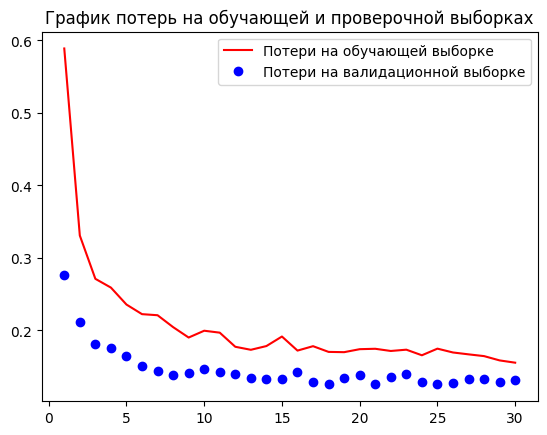

In [ ]:
def plot_history(history):
    acc = history.history['acc']              # данные о точности на обучающей выборке
    val_acc = history.history['val_acc']      # данные о точности на проверочной выборке
    loss = history.history['loss']            # данные об ошибке на обучающей выборке
    val_loss = history.history['val_loss']    # данные об ошибке на проверочной выборке
    epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
    plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
    plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
    plt.legend()                                                               #  легенда графика
    plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
    plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
    plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
    plt.legend()                                                               #  легенда графика
    plt.show()

plot_history(history)

## Проверка модели

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Точность на контрольной выборке:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - acc: 0.9528 - loss: 0.1197
Точность на контрольной выборке: 0.9520000219345093
